# Model Training and Evaluation

This notebook trains and evaluates two LSTM models to predict Boeing’s stock price: a baseline model using only historical price features, and a causally-informed model enhanced with features from stocks identified via CD-NOD. Model performance is compared using MSE, RMSE, and MAE.

## Assumptions from CD-NOD
- Data is stationary - not needed
- indep_Test: fisherz | this assumes linear relationsips (trry other tests that don't assume linearity)

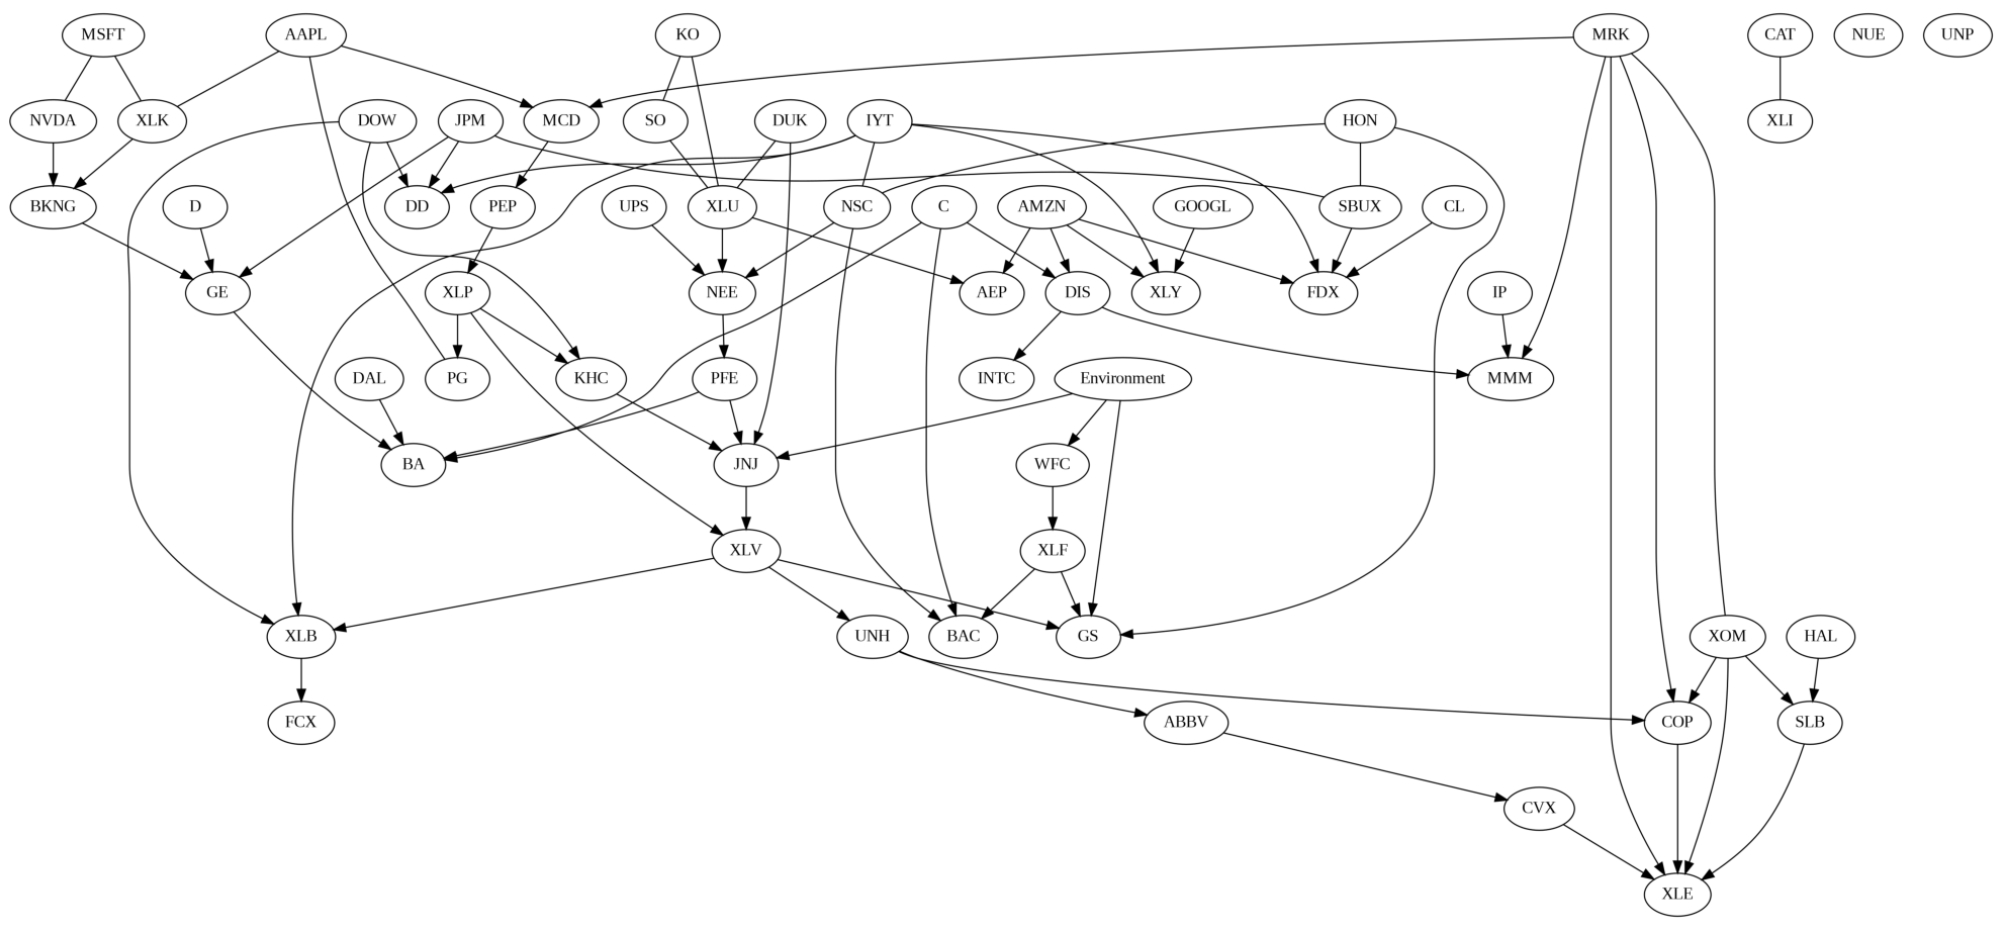

## Tech Cluster:
- MSFT → NVDA → BKNG shows a clear causal chain
- AAPL has multiple connections and influences on other stocks
- XLK (Technology ETF) shows logical connections to tech companies

## Financial Cluster:
- JPM → BAC → GS shows strong financial sector interconnections
- XLF (Financial ETF) appropriately connects to major banks

## Consumer/Retail Chain:
- AMZN → XLY (Consumer Discretionary ETF) shows logical relationship
- MCD (McDonald's) connections to consumer-related stocks

## Logical Consistencies
- Sector ETFs (XLF, XLK, XLB) show appropriate connections to their constituent stocks
- Related companies within sectors show connections (e.g., financial companies)
- The "Environment" node's connections to financial stocks make sense given market sensitivity

## Questionable Aspects
- GOOGL appears relatively isolated from other tech companies
- Some major companies like MSFT have fewer connections than expected
- Some cross-sector relationships seem arbitrary

## Isolated nodes:
- UNP, NUE, and CAT appear disconnected

In [1]:
# deciding target stock

## 1. General Electric (GE)

Incoming:
- Dominion Energy (D)
- Nvidia (NVDA) -> Booking holidays (BKNG)
- Nvidia (NVDA) -> Booking holidays (BKNG)
- JP Morgan (JPM)

## 2. Boeing (BA)

Incoming:
- CitiGroup (C)
- Pfizer (PFE)
- General Electric (GE)
- Delta Air Lines (DAL)



# Model training for Boeing

In [ ]:
# ! pip install numpy
# ! pip install yfinance
# ! pip install pandas
# ! pip install matplotlib
# ! pip install scikit-learn
# ! pip install tensorflow

In [128]:
import yfinance as yf
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.regularizers import l2
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

## Baseline 

In [148]:
def get_stock_data(ticker='BA', start='2020-01-01', end='2024-11-30'):
    # Get stock data
    df = yf.download(ticker, start=start, end=end)
    
    # Get VIX data
    vix = yf.download('^VIX', start=start, end=end)['Close']
    df['VIX'] = vix
    
    return df

def add_technical_indicators(df):
    # Price-based indicators
    df['MA5'] = df['Close'].rolling(window=5).mean()
    df['MA20'] = df['Close'].rolling(window=20).mean()
    df['MA50'] = df['Close'].rolling(window=50).mean()
    
    # momemtum
    df['RSI'] = calculate_rsi(df['Close'], periods=14)
    
    # volatility
    df['Daily_Return'] = df['Close'].pct_change()
    df['Volatility'] = df['Daily_Return'].rolling(window=20).std()
    
    # volume
    df['Volume_MA5'] = df['Volume'].rolling(window=5).mean()
    df['Volume_MA20'] = df['Volume'].rolling(window=20).mean()
    
    # vix related
    df['VIX_MA5'] = df['VIX'].rolling(window=5).mean()
    df['VIX_Change'] = df['VIX'].pct_change()

    # cyclical
    df['Day_Sin'] = np.sin(2 * np.pi * df.index.dayofweek / 7)
    df['Day_Cos'] = np.cos(2 * np.pi * df.index.dayofweek / 7)
    df['Month_Sin'] = np.sin(2 * np.pi * df.index.month / 12)
    df['Month_Cos'] = np.cos(2 * np.pi * df.index.month / 12)

    # lagged
    df['Prev_Close'] = df['Close'].shift(1)
    
    return df

def calculate_rsi(prices, periods=14):
    delta = prices.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=periods).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=periods).mean()
    rs = gain / loss
    return 100 - (100 / (1 + rs))

"""
features = ['Close', 'MA5', 'MA20', 'MA50', 'RSI', 'Volatility', 
            'Volume', 'Volume_MA5', 'Volume_MA20', 'Daily_Return',
            'VIX', 'VIX_MA5', 'VIX_Change', 'Day_Sin', 'Day_Cos', 'Month_Sin', 'Month_Cos', 'Prev_Close']


features = ['Close', 'MA5', 'MA20', 'MA50', 'RSI', 'Volatility', 
            'Volume', 'Volume_MA5', 'Volume_MA20', 'Daily_Return',
            'VIX', 'VIX_MA5', 'VIX_Change']
"""
features = ['Close', 'MA5', 'MA20','RSI', 'Volatility', 
            'Volume', 'Volume_MA5', 'Daily_Return']

def prepare_lstm_data(df, look_back=60, train_end='2022-06-30', val_end='2023-06-30'):
    
    
    df = df.dropna()
    
    train_end_dt = pd.to_datetime(train_end)
    val_end_dt = pd.to_datetime(val_end)
    
    # temporal splti + lookback mapping
    train_data = df[df.index <= train_end_dt][features]
    val_data = df[(df.index > train_end_dt + pd.Timedelta(days=look_back)) & 
              (df.index <= val_end_dt)][features]
    test_data = df[df.index > val_end_dt + pd.Timedelta(days=look_back)][features]

    print(f"Training:   {train_data.index[0]} to {train_data.index[-1]}")
    print(f"Validation: {val_data.index[0]} to {val_data.index[-1]}")
    print(f"Testing:    {test_data.index[0]} to {test_data.index[-1]}")

    
    scaler = MinMaxScaler()
    train_scaled = scaler.fit_transform(train_data)
    val_scaled = scaler.transform(val_data)
    test_scaled = scaler.transform(test_data)
    
    
    # train_scaled = train_data.values
    # val_scaled = val_data.values
    # test_scaled = test_data.values
    
    
    def create_sequences(data, lookback=60):
        X, y = [], []
        for i in range(lookback, len(data)):
            sequence = data[i-lookback:i]
            if len(sequence) == lookback: # checking for complete seqs
                X.append(sequence)
                y.append(data[i, 0])
        return np.array(X), np.array(y)
    
    # set sequences
    X_train, y_train = create_sequences(train_scaled)
    X_val, y_val = create_sequences(val_scaled)
    X_test, y_test = create_sequences(test_scaled)
    
    train_indices = train_data.index[look_back:]
    val_indices = val_data.index[look_back:]
    test_indices = test_data.index[look_back:]
    
    return (X_train, y_train, 
            X_val, y_val, 
            X_test, y_test, 
            scaler, 
            train_indices, 
            val_indices, 
            test_indices,
           train_scaled,
           test_scaled,
           val_scaled)

def create_lstm_model(input_shape):
    
    model = Sequential([
            LSTM(units=128, return_sequences=True, input_shape=input_shape),
            Dropout(0.3),
            LSTM(units=128, return_sequences=True),
            Dropout(0.1),
            LSTM(units=128, return_sequences=False),
            Dense(units=1)
        ])
    """
    
    model = Sequential([
    LSTM(units=50, return_sequences=True),
    BatchNormalization(),
    Dropout(0.2),
    LSTM(units=50, return_sequences=True),
    Dropout(0.2),
    LSTM(units=50),
    Dropout(0.2),
    Dense(units=1)
])

    model = LSTM(units=50, return_sequences=True, input_shape=input_shape), 
        Dropout(0.2),
        LSTM(units=50, return_sequences=True),
        Dropout(0.2),
        LSTM(units=50),
        Dropout(0.2),
        Dense(units=1)
    ])
    """
    model.compile(optimizer=Adam(learning_rate=0.0007), loss='mse') # 0.001
    return model

def evaluate_model(y_true, y_pred, scaler, name=""):
    # Inverse transform predictions if needed
    if scaler is not None:
        y_true = scaler.inverse_transform(np.concatenate((y_true.reshape(-1,1), 
                 np.zeros((len(y_true), len(features)-1))), axis=1))[:, 0]
        y_pred = scaler.inverse_transform(np.concatenate((y_pred.reshape(-1,1), 
                 np.zeros((len(y_pred), len(features)-1))), axis=1))[:, 0]
    
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    
    print(f"\n{name} Performance Metrics:")
    print(f"MSE: {mse:.2f}")
    print(f"RMSE: {rmse:.2f}")
    print(f"MAE: {mae:.2f}")
    # print(f"R2 Score: {r2:.4f}")
    
    return mse, rmse, mae #, r2

In [149]:
df = get_stock_data()
df = add_technical_indicators(df)

# X_train, y_train, X_test, y_test, scaler, train_idx, test_idx = prepare_lstm_data(df)
X_train, y_train, X_val, y_val, X_test, y_test, scaler, train_idx, val_idx, test_idx, train_scaled, test_scaled, val_scaled = prepare_lstm_data(df)

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    mode='min',
    restore_best_weights=True,
    verbose=1
)

# training
model = create_lstm_model(input_shape=(X_train.shape[1], X_train.shape[2]))
history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping],
    verbose=1
)

# preds
train_predictions = model.predict(X_train)
val_predictions = model.predict(X_val)
test_predictions = model.predict(X_test)

train_metrics = evaluate_model(y_train, train_predictions, scaler, "Training")
val_metrics = evaluate_model(y_val, val_predictions, scaler, "Validation")
test_metrics = evaluate_model(y_test, test_predictions, scaler, "Testing")

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Training:   2020-03-13 00:00:00 to 2022-06-30 00:00:00
Validation: 2022-08-30 00:00:00 to 2023-06-30 00:00:00
Testing:    2023-08-30 00:00:00 to 2024-11-29 00:00:00
Epoch 1/50



/Users/neerajchhimwal/anaconda3/envs/finance_causal/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - loss: 0.2170 - val_loss: 0.0020
Epoch 2/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - loss: 0.0148 - val_loss: 0.0037
Epoch 3/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 0.0123 - val_loss: 0.0047
Epoch 4/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 87ms/step - loss: 0.0101 - val_loss: 0.0018
Epoch 5/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 83ms/step - loss: 0.0092 - val_loss: 0.0017
Epoch 6/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 0.0080 - val_loss: 0.0017
Epoch 7/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 83ms/step - loss: 0.0091 - val_loss: 0.0016
Epoch 8/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 0.0072 - val_loss: 0.0015
Epoch 9/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step - loss: 0.0063 - val_loss: 0.0015
Epoch 10/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step - loss: 0.0073 - val_loss: 0.0016
Epoch 11/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step - loss: 0.0082 - val_loss: 0.0020
Epoch 12/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - loss: 0.0067 - val_l

In [152]:
df.shape

(1237, 22)

In [151]:
X_train.shape

(520, 60, 8)

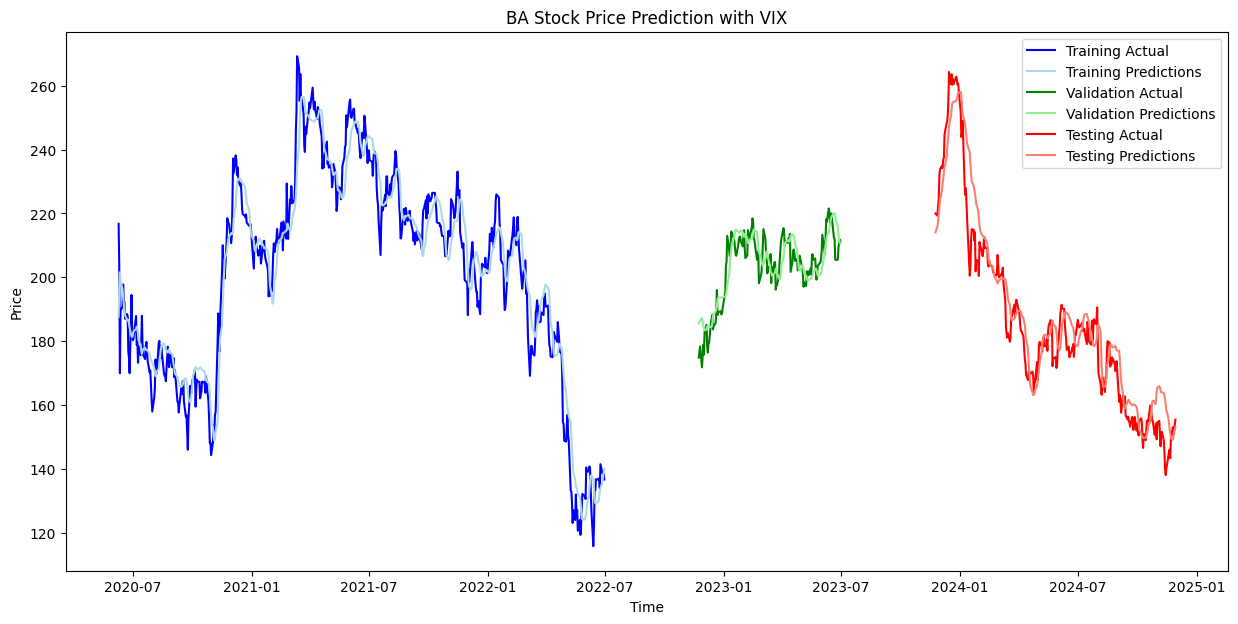

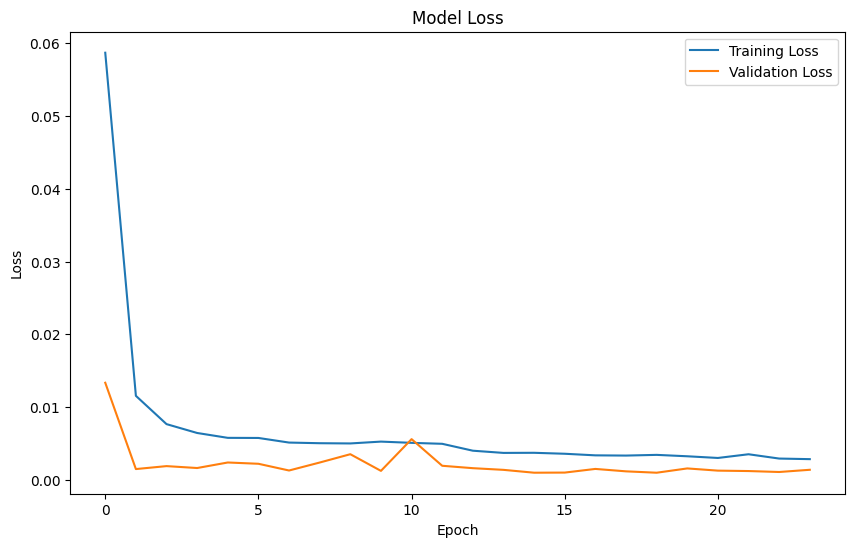

In [141]:
# Plot results
plt.figure(figsize=(15, 7))

# Training period
plt.plot(train_idx, scaler.inverse_transform(np.concatenate(
         (y_train.reshape(-1,1), np.zeros((len(y_train), 12))), axis=1))[:, 0], 
         label='Training Actual', color='blue')
plt.plot(train_idx, scaler.inverse_transform(np.concatenate(
         (train_predictions, np.zeros((len(train_predictions), 12))), axis=1))[:, 0], 
         label='Training Predictions', color='lightblue')

# Validation period
plt.plot(val_idx, scaler.inverse_transform(np.concatenate(
         (y_val.reshape(-1,1), np.zeros((len(y_val), 12))), axis=1))[:, 0], 
         label='Validation Actual', color='green')
plt.plot(val_idx, scaler.inverse_transform(np.concatenate(
         (val_predictions, np.zeros((len(val_predictions), 12))), axis=1))[:, 0], 
         label='Validation Predictions', color='lightgreen')

# Testing period
plt.plot(test_idx, scaler.inverse_transform(np.concatenate(
         (y_test.reshape(-1,1), np.zeros((len(y_test), 12))), axis=1))[:, 0], 
         label='Testing Actual', color='red')
plt.plot(test_idx, scaler.inverse_transform(np.concatenate(
         (test_predictions, np.zeros((len(test_predictions), 12))), axis=1))[:, 0], 
         label='Testing Predictions', color='salmon')

plt.title('BA Stock Price Prediction with VIX')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

# Plot training history
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


# Results

## Feauters for Exp 1- 10:     
features = ['Close', 'MA5', 'MA20', 'MA50', 'RSI', 'Volatility', 
                'Volume', 'Volume_MA5', 'Volume_MA20', 'Daily_Return',
                'VIX', 'VIX_MA5', 'VIX_Change']
## Exp 1
### Architecture:
LSTM(units=50, return_sequences=True, input_shape=input_shape), 
        Dropout(0.2),
        LSTM(units=50, return_sequences=True),
        Dropout(0.2),
        LSTM(units=50),
        Dropout(0.2),
        Dense(units=1)

### Results:
Training Performance Metrics: <br>
MSE: 146.00 <br>
RMSE: 12.08 <br>
MAE: 8.99 <br>
R2 Score: 0.8651 <br>

Validation Performance Metrics: <br>
MSE: 42.83 <br>
RMSE: 6.54 <br>
MAE: 5.21 <br>
R2 Score: 0.6355 <br>

Testing Performance Metrics: <br>
MSE: 107.09 <br>
RMSE: 10.35 <br>
MAE: 8.02 <br>
R2 Score: 0.8738

## Exp 2
### Architecture:
model = Sequential([
        LSTM(units=128, return_sequences=True, input_shape=input_shape),
        Dropout(0.2),
        LSTM(units=64, return_sequences=True),
        Dropout(0.2),
        LSTM(units=64),
        model.add(LSTM(64, return_sequences=False))
        model.add(Dense(25))
        model.add(Dense(1))
        Dense(units=1)

### Results:
Training Performance Metrics:
MSE: 167.82
RMSE: 12.95
MAE: 9.80
R2 Score: 0.8449

Validation Performance Metrics:
MSE: 45.39
RMSE: 6.74
MAE: 5.50
R2 Score: 0.6136

Testing Performance Metrics:
MSE: 114.53
RMSE: 10.70
MAE: 8.36
R2 Score: 0.8650

## Exp 3
### Architecture:
model = Sequential([
        LSTM(units=128, return_sequences=True, input_shape=input_shape),
        Dropout(0.2),
        LSTM(units=64, return_sequences=True),
        Dropout(0.2),
        LSTM(64, return_sequences=False))
        model.add(Dense(1))
        Dense(units=1)
    ])

### Results:
Training Performance Metrics:
MSE: 207.51
RMSE: 14.41
MAE: 11.03
R2 Score: 0.8082

Validation Performance Metrics:
MSE: 49.15
RMSE: 7.01
MAE: 5.62
R2 Score: 0.5816

Testing Performance Metrics:
MSE: 208.58
RMSE: 14.44
MAE: 12.16
R2 Score: 0.7542

## Exp 4
### Architecture:
model = Sequential([
        LSTM(units=128, return_sequences=True, input_shape=input_shape),
        Dropout(0.2),
        LSTM(units=64, return_sequences=True),
        Dropout(0.2),
        LSTM(64, return_sequences=False)),
        Dense(units=1)
    ])
    
### Results:
Training Performance Metrics:
MSE: 173.59
RMSE: 13.18
MAE: 10.08
R2 Score: 0.8396

Validation Performance Metrics:
MSE: 48.29
RMSE: 6.95
MAE: 5.55
R2 Score: 0.5890

Testing Performance Metrics:
MSE: 136.66
RMSE: 11.69
MAE: 9.14
R2 Score: 0.8389

## Exp 5
### Architecture:
model = Sequential([
        LSTM(units=128, return_sequences=True, input_shape=input_shape),
        Dropout(0.1),
        LSTM(units=128, return_sequences=True),
        Dropout(0.1),
        LSTM(units=64, return_sequences=False),
        Dense(units=1)
    ])

### Results:
Training Performance Metrics:
MSE: 142.19
RMSE: 11.92
MAE: 9.06
R2 Score: 0.8686

Validation Performance Metrics:
MSE: 39.12
RMSE: 6.25
MAE: 5.06
R2 Score: 0.6670

Testing Performance Metrics:
MSE: 100.50
RMSE: 10.02
MAE: 7.80
R2 Score: 0.8816

## Exp 6
### Architecture:
model = Sequential([
        LSTM(units=128, return_sequences=True, input_shape=input_shape),
        Dropout(0.1),
        LSTM(units=128, return_sequences=True),
        Dropout(0.1),
        LSTM(units=64, return_sequences=False),
        Dense(units=25),
        Dense(units=1)
    ])

### Results:
Training Performance Metrics:
MSE: 142.98
RMSE: 11.96
MAE: 9.03

Validation Performance Metrics:
MSE: 44.65
RMSE: 6.68
MAE: 5.29

Testing Performance Metrics:
MSE: 121.71
RMSE: 11.03
MAE: 8.60

## Exp 7
### Architecture:
    model = Sequential([
        LSTM(units=128, return_sequences=True, input_shape=input_shape),
        Dropout(0.1),
        LSTM(units=64, return_sequences=True),
        Dropout(0.1),
        LSTM(units=32, return_sequences=False),
        Dense(units=1)
    ])

### Results:
Training Performance Metrics:
MSE: 147.83
RMSE: 12.16
MAE: 9.19

Validation Performance Metrics:
MSE: 43.53
RMSE: 6.60
MAE: 5.20

Testing Performance Metrics:
MSE: 136.52
RMSE: 11.68
MAE: 9.19

## Exp 8
### Architecture:
    model = Sequential([
            LSTM(units=128, return_sequences=True, input_shape=input_shape),
            Dropout(0.1),
            LSTM(units=128, return_sequences=True),
            Dropout(0.1),
            LSTM(units=128, return_sequences=True),
            Dense(units=1)
        ])
        
### Results:
Training Performance Metrics:
MSE: 100.93
RMSE: 10.05
MAE: 7.73

Validation Performance Metrics:
MSE: 41.51
RMSE: 6.44
MAE: 5.13

Testing Performance Metrics:
MSE: 93.38
RMSE: 9.66
MAE: 7.50

## Exp 9 - Best
### Architecture:
model = Sequential([
            LSTM(units=128, return_sequences=True, input_shape=input_shape),
            Dropout(0.1),
            LSTM(units=128, return_sequences=True),
            LSTM(units=128, return_sequences=False),
            Dense(units=1)
        ])
        
### Results:
Training Performance Metrics:
MSE: 54.90
RMSE: 7.41
MAE: 5.78

Validation Performance Metrics:
MSE: 25.62
RMSE: 5.06
MAE: 3.91

Testing Performance Metrics:
MSE: 67.18
RMSE: 8.20
MAE: 6.29
 
## Exp 10 -- Best 2
### Architecture:
model = Sequential([
            LSTM(units=128, return_sequences=True, input_shape=input_shape),
            Dropout(0.3),
            LSTM(units=128, return_sequences=True),
            Dropout(0.1),
            LSTM(units=128, return_sequences=False),
            Dense(units=1)
        ])
        
### Results:
Training Performance Metrics:
MSE: 91.27
RMSE: 9.55
MAE: 7.39

Validation Performance Metrics:
MSE: 31.32
RMSE: 5.60
MAE: 4.32

Testing Performance Metrics:
MSE: 86.01
RMSE: 9.27
MAE: 7.39

## Features for Exp 11
    features = ['Close', 'MA5', 'MA20', 'MA50', 'RSI', 'Volatility', 
                'Volume', 'Volume_MA5', 'Volume_MA20', 'Daily_Return',
                'VIX', 'VIX_MA5', 'VIX_Change', 'Day_Sin', 'Day_Cos', 'Month_Sin', 'Month_Cos', 'Prev_Close']
## Exp 11
### Architecture:
model = Sequential([
            LSTM(units=128, return_sequences=True, input_shape=input_shape),
            Dropout(0.3),
            LSTM(units=128, return_sequences=True),
            Dropout(0.1),
            LSTM(units=128, return_sequences=False),
            Dense(units=1)
        ])

### Results:
not good

## Exp 12
### Architecture:
model = Sequential([
            LSTM(units=128, return_sequences=True, input_shape=input_shape),
            Dropout(0.3),
            LSTM(units=128, return_sequences=True),
            Dropout(0.1),
            LSTM(units=128, return_sequences=False),
            Dense(units=1)
        ])


